In [34]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D, Flatten, Conv1D, \
                                    Conv2D, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Lambda, ELU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
META_DIR = Path('../data/fma_metadata')
AUDIO_DIR = Path('../data/fma_small')
CONVERTED_DIR = Path('../data/converted/rock_inst')

In [25]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
genre_dict = {'Rock':0, 'Instrumental': 1}

reverse_map = {v: k for k, v in genre_dict.items()}
print(reverse_map)

{0: 'Rock', 1: 'Instrumental'}


In [4]:
npzfile = np.load(CONVERTED_DIR/'train_arr.npz')
X_train = npzfile['X']
y_train = npzfile['y']
print(X_train.shape, y_train.shape)

In [5]:
npzfile = np.load(CONVERTED_DIR/'valid_arr.npz')
X_valid = npzfile['X']
y_valid = npzfile['y']
print(X_valid.shape, y_valid.shape)

In [8]:
# Sanity check - plot Spectogram

# num = 0
# spectogram = X_train[num]
# genre = np.argmax(y_train[num])
# print(reverse_map[genre])
# plt.figure(figsize=(10, 5))
# librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Test Melspectogram')
# plt.tight_layout()

In [9]:
# Add dimension for single channel for Conv2D
X_train = X_train[...,None]
X_valid = X_valid[...,None]

# Build model
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape = (640, 128, 1), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 636, 124, 32)      832       
_________________________________________________________________
dropout_6 (Dropout)          (None, 636, 124, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 634, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 317, 61, 32)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 317, 61, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 618784)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [20]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5,
                    validation_data=(X_valid, y_valid), verbose=1)


Train on 1599 samples, validate on 200 samples
Epoch 1/5
1599/1599 [==============================] - 26s 16ms/sample - loss: 7.7186 - accuracy: 0.4984 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
1599/1599 [==============================] - 21s 13ms/sample - loss: 7.7081 - accuracy: 0.4997 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
1599/1599 [==============================] - 21s 13ms/sample - loss: 7.7081 - accuracy: 0.5003 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
1599/1599 [==============================] - 21s 13ms/sample - loss: 7.7081 - accuracy: 0.5003 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
1599/1599 [==============================] - 21s 13ms/sample - loss: 7.7081 - accuracy: 0.5003 - val_loss: 7.7125 - val_accuracy: 0.5000


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


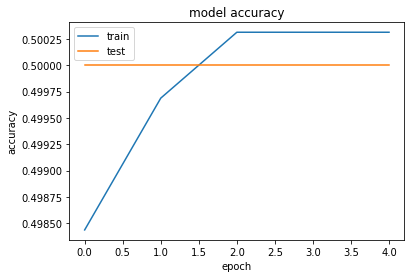

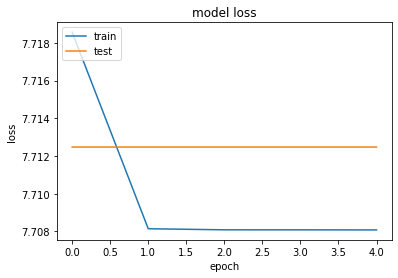

In [26]:
show_summary_stats(history)

# Try model from blog
https://github.com/priya-dwivedi/Music_Genre_Classification/blob/master/CRNN_model.ipynb

In [27]:
# Reload train and test
npzfile = np.load(CONVERTED_DIR/'train_arr.npz')
X_train = npzfile['X']
y_train = npzfile['y']

npzfile = np.load(CONVERTED_DIR/'valid_arr.npz')
X_valid = npzfile['X']
y_valid = npzfile['y']


In [59]:
y_train[:5]

array([0, 0, 1, 0, 1])

In [50]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [51]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 50
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.0004)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [55]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/crnn_weights_best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, 
                                          patience=10, min_delta=0.01, verbose=1)
    
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, 
                        callbacks=callbacks_list)

    return model, history


In [56]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 128)]       0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_25 (Batc (None, None, 56)          224       
_________________________________________________________________
activation_25 (Activation)   (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, None, 56)          0         
_________________________________________________________________
dropout_49 (Dropout)         (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None,

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


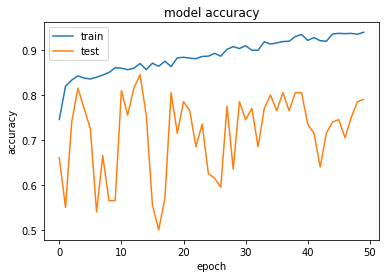

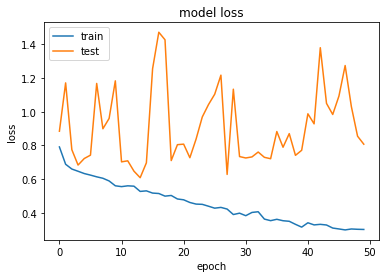

In [57]:
show_summary_stats(history)